In [1]:
import os
import random
import subprocess
import time
import datetime

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

seed        = 0
save_num    = 599
seq_len     = 100000
temperature = 1.0

In [2]:
class UDNet(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout):
        super(UDNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.init_hiddens = nn.Parameter(torch.randn(num_layers, 1, hidden_size))
        self.init_cells   = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        self.embed = nn.Embedding(num_embeddings=129, embedding_dim=hidden_size)

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        self.fc0 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=hidden_size, out_features=256)
        )

        self.fc1 = nn.Sequential(
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=512)
        )

        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=512, out_features=129)
        )

    def forward(self, x, hiddens=None):
        if hiddens is None:
            hiddens = self.get_init_hiddens(x.size(0))

        x = self.embed(x)

        x, new_hiddens = self.lstm(x, hiddens)

        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x, new_hiddens

    def get_init_hiddens(self, n_batches):
        return [self.init_hiddens.repeat(1, n_batches, 1), self.init_cells.repeat(1, n_batches, 1)]

In [3]:
def free_running_generation(generator, inputs, seq_len, temperature=1.0):
    """
    Params
    ======
    generator (Generator): the generator model.
    inputs (LongTensor): 2D tensor with dimensions [n_batches, 1].
                         If the given dimensions are [n_batches, seq_len],
                         then only the first timestep is used.
    seq_len (int): length of sequence to generate.
    temperature (float, optional): temperature for sampling from probability distribution

    Returns
    =======
    output_sequence (LongTensor): tensor of generated outputs.
    hiddens (list[Tensor]): updated hidden states.
    """
    assert temperature > 0
    output_sequence = []

    hiddens = generator.get_init_hiddens(inputs.size(0))
    x = inputs[:, :1]

    for i in range(seq_len):
        if i % 100 == 0:
            print("{:d}/{:d}".format(i, seq_len-1), end='\r')
        y, hiddens = generator(x, hiddens)
        y = torch.multinomial(y.squeeze(1).div(temperature).softmax(dim=-1), num_samples=1)
        output_sequence.append(y)
        x = y
    print("{m:d}/{m:d}".format(m=seq_len-1))
    output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence, hiddens

In [4]:
def plot(d, fontsize=20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 9), facecolor="lightsteelblue")

    for ax in axes:
        ax.set_xlabel("Epoch", fontsize=fontsize)
        ax.grid(True)
        ax.set_facecolor("slategray")

    axes[0].set_title("Learning Rate", fontsize=fontsize)
    axes[0].set_ylabel("LR", fontsize=fontsize)
    axes[0].plot(d['logs']['epoch'], d['logs']['lr'])

    axes[1].set_title("Training Losses", fontsize=fontsize)
    axes[1].set_ylabel("Loss", fontsize=fontsize)
    axes[1].plot(d['logs']['epoch'], d['logs']['loss_avg'])

    axes[2].set_title("Accuracies", fontsize=fontsize)
    axes[2].set_ylabel("Accuracy", fontsize=fontsize)
    axes[2].plot(d['logs']['epoch'], d['logs']['acc_1'], label="Top-1 Acc", color='blue')
    axes[2].plot(d['logs']['epoch'], d['logs']['acc_5'], label="Top-5 Acc", color='orange')
    axes[2].legend()

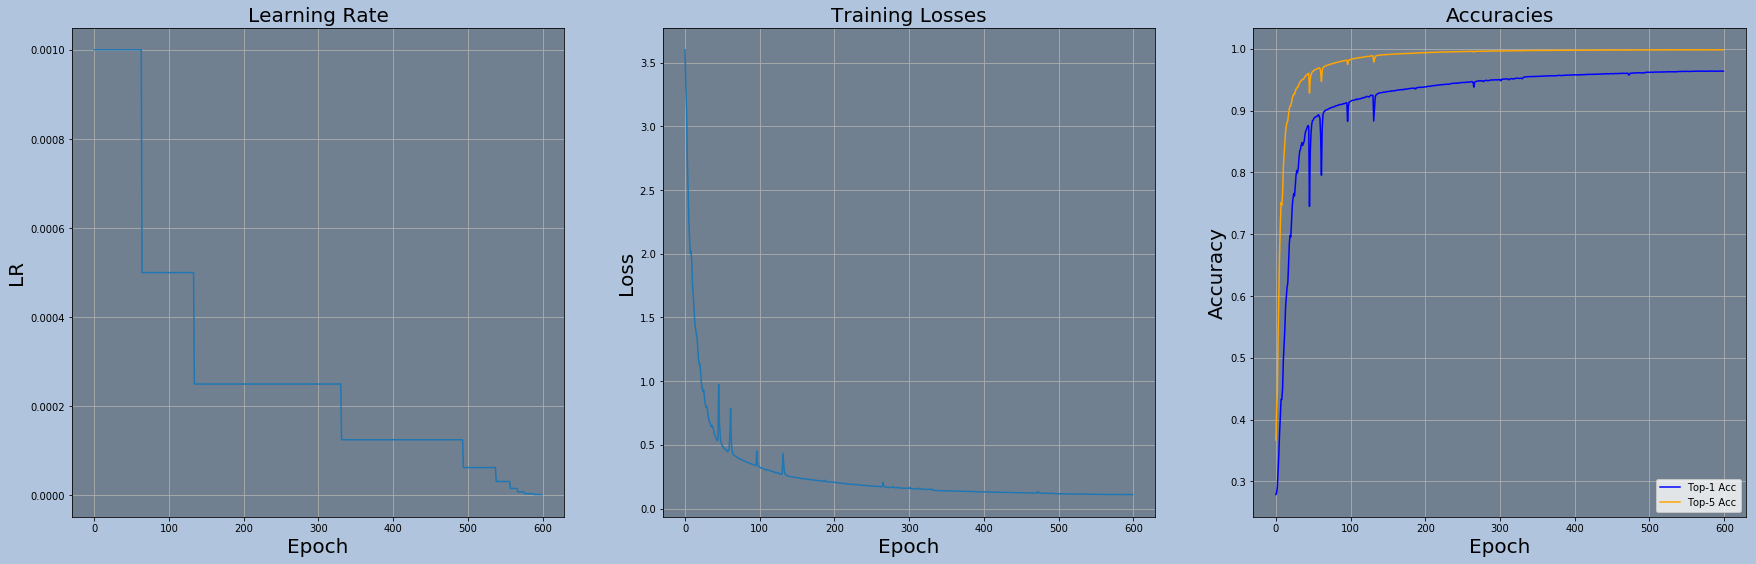

In [5]:
d = torch.load("{:d}.pth".format(save_num), map_location=torch.device('cpu'))

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_layers, _, hidden_size = d['state_dict']['init_hiddens'].size()

model = UDNet(hidden_size=hidden_size, num_layers=num_layers, dropout=0.)
model.load_state_dict(d['state_dict'])
model.eval()
plot(d)

In [6]:
with torch.no_grad():
    t0 = time.time()
    generated_sequence = free_running_generation(model, torch.randint(0, 129, size=(1, 1), dtype=torch.long), seq_len, temperature)[0][0].tolist()
    t1= time.time()

    root_dir = './{:d}/'.format(save_num)
    i = 0
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
        file_dir = os.path.join(root_dir, str(i))
    else:
        while True:
            file_dir = os.path.join(root_dir, str(i))
            if str(i) in os.listdir(root_dir) and os.path.isdir(file_dir):
                i += 1
            else:
                break
    os.mkdir(file_dir)
    with open(os.path.join(file_dir, 'info.txt'), 'w') as f:
        t = datetime.datetime.now(datetime.timezone.utc)
        f.write(t.strftime("%H:%M:%S %A, %B %d, %Y %Z") + '\n' + t.astimezone().strftime("%H:%M:%S %A, %B %d, %Y %Z")
                + "\n\nSeed: {:d}\nGenerated Sequence Length: {:d}\nTemperature: {:f}".format(seed, seq_len, temperature)
                + "\n\nTime taken for generation process: {:.3f} seconds".format(t1 - t0))
    seed        = 0
    save_num    = 139
    seq_len     = 300000
    temperature = 1.0
    file_name = os.path.join(file_dir, "generated")
    with open(file_name + '.txt', 'w') as f:
        f.write(' '.join([str(num) for num in generated_sequence]))

    print(subprocess.run(["python", "../utils/text_to_csv.py", "--ticks", "25", file_name + ".txt"]))
    print(subprocess.run(["../utils/Csvmidi.exe", file_name + ".csv", file_name + ".mid"]))
    print(subprocess.run(["python", "../utils/visualize.py", "-z", "--ticks", "30", "-c", file_name + ".csv", "-r", file_dir]))

    path = os.path.join(file_dir, "merged/")
    f_name = os.path.join(path, "generated")
    os.mkdir(path)
    print(subprocess.run(["python", "../utils/text_to_csv.py", "-m", "1", "--ticks", "25", file_name + ".txt", f_name + ".csv"]))
    print(subprocess.run(["../utils/Csvmidi.exe", f_name + ".csv", f_name + ".mid"]))
    print(subprocess.run(["python", "../utils/visualize.py", "-z", "--ticks", "30", "-c", f_name + ".csv", "-r", path]))

    path = os.path.join(file_dir, "filtered/")
    f_name = os.path.join(path, "generated")
    os.mkdir(path)
    print(subprocess.run(["python", "../utils/text_to_csv.py", "-f", "1", "--ticks", "25", file_name + ".txt", f_name + ".csv"]))
    print(subprocess.run(["../utils/Csvmidi.exe", f_name + ".csv", f_name + ".mid"]))
    print(subprocess.run(["python", "../utils/visualize.py", "-z", "--ticks", "30", "-c", f_name + ".csv", "-r", path]))

    path = os.path.join(file_dir, "filtered_merged/")
    f_name = os.path.join(path, "generated")
    os.mkdir(path)
    print(subprocess.run(["python", "../utils/text_to_csv.py", "-f", "1", "-m", "1", "--ticks", "25", file_name + ".txt", f_name + ".csv"]))
    print(subprocess.run(["../utils/Csvmidi.exe", f_name + ".csv", f_name + ".mid"]))
    print(subprocess.run(["python", "../utils/visualize.py", "-z", "--ticks", "30", "-c", f_name + ".csv", "-r", path]))

    path = os.path.join(file_dir, "merged_filtered/")
    f_name = os.path.join(path, "generated")
    os.mkdir(path)
    print(subprocess.run(["python", "../utils/text_to_csv.py", "-f", "1", "-m", "1", "--merge-first", "--ticks", "25", file_name + ".txt", f_name + ".csv"]))
    print(subprocess.run(["../utils/Csvmidi.exe", f_name + ".csv", f_name + ".mid"]))
    print(subprocess.run(["python", "../utils/visualize.py", "-z", "--ticks", "30", "-c", f_name + ".csv", "-r", path]))

99999/99999
CompletedProcess(args=['python', '../utils/text_to_csv.py', '--ticks', '25', './599/0\\generated.txt'], returncode=0)
CompletedProcess(args=['../utils/Csvmidi.exe', './599/0\\generated.csv', './599/0\\generated.mid'], returncode=0)
CompletedProcess(args=['python', '../utils/visualize.py', '-z', '--ticks', '30', '-c', './599/0\\generated.csv', '-r', './599/0'], returncode=0)
CompletedProcess(args=['python', '../utils/text_to_csv.py', '-m', '1', '--ticks', '25', './599/0\\generated.txt', './599/0\\merged/generated.csv'], returncode=0)
CompletedProcess(args=['../utils/Csvmidi.exe', './599/0\\merged/generated.csv', './599/0\\merged/generated.mid'], returncode=0)
CompletedProcess(args=['python', '../utils/visualize.py', '-z', '--ticks', '30', '-c', './599/0\\merged/generated.csv', '-r', './599/0\\merged/'], returncode=0)
CompletedProcess(args=['python', '../utils/text_to_csv.py', '-f', '1', '--ticks', '25', './599/0\\generated.txt', './599/0\\filtered/generated.csv'], returncode

---